Bước 1: Import các thư viện cần thiết thiết

In [19]:
import sys
from functools import reduce
from cv2 import dft
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, sum as spark_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
dft.info() 

AttributeError: 'builtin_function_or_method' object has no attribute 'info'

Bước 2: Tạo Spark Session và đọc dữ liệu CSV

In [ ]:
# Tạo Spark Session
spark = SparkSession.builder.appName("MovieTrendPrediction_Optimized").getOrCreate()

# Đọc dữ liệu CSV
data_path = r"C:/CONG NGHE THONG TIN/Dữ Liệu Lớn/BTL_BigData/movies_cleaned.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

print("=== 5 dòng đầu dữ liệu ===")
df.show(5)


=== 5 dòng đầu dữ liệu ===
+------------+----------+------------+----------+-------+---------+----------+----+-----+----------+------------+---------------+---------------+------------+-----------+-----------------+-----------+------------+-------------+-------------+------------+-----------+-------------+-------------+---------------------+--------------+--------------+---------+-------------+
|vote_average|vote_count|release_date|   revenue|runtime|   budget|popularity|year|month|    profit|genre_Action|genre_Adventure|genre_Animation|genre_Comedy|genre_Crime|genre_Documentary|genre_Drama|genre_Family|genre_Fantasy|genre_History|genre_Horror|genre_Music|genre_Mystery|genre_Romance|genre_Science Fiction|genre_TV Movie|genre_Thriller|genre_War|genre_Western|
+------------+----------+------------+----------+-------+---------+----------+----+-----+----------+------------+---------------+---------------+------------+-----------+-----------------+-----------+------------+-------------+----

Bước 3: Tính median của profit và tạo biến target 'trend'

In [ ]:
# Tính median của profit
median_profit = df.approxQuantile("profit", [0.5], 0.01)[0]
print(f"Median profit: {median_profit}")

# Tạo biến target 'trend'
df = df.withColumn("trend", when(col("profit") >= median_profit, 1).otherwise(0))


Median profit: 0.0


Bước 4: Loại bỏ các cột không cần thiết và xác định danh sách features ban đầu

In [ ]:
# Loại bỏ các cột không cần thiết (tránh rò rỉ thông tin)
drop_cols = ['release_date', 'revenue', 'budget', 'profit', 'popularity', 'month', 'year']
df = df.drop(*drop_cols)
print("=== Các cột còn lại:", df.columns)

# Xác định danh sách feature (ngoại trừ target 'trend')
feature_cols = [c for c in df.columns if c != "trend"]
print("=== Features ban đầu:", feature_cols)


=== Các cột còn lại: ['vote_average', 'vote_count', 'runtime', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'trend']
=== Features ban đầu: ['vote_average', 'vote_count', 'runtime', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western']


Bước 6: Xử lý cột genre – Gom các cột genre hiếm thành 'genre_rare'

In [ ]:
# Xác định các cột genre
genre_cols = [c for c in feature_cols if c.startswith("genre_")]

# Tính tổng số dòng
total = df.count()
genre_threshold = 0.05

# Lọc các cột genre hiếm (ratio < 0.05)
sparse_genres = [
    g for g in genre_cols 
    if df.agg(spark_sum(col(g)).alias("ones")).first()["ones"] / total < genre_threshold
]
print(f"=== Các cột genre hiếm (ratio < {genre_threshold}):", sparse_genres)

# Nếu có các cột hiếm, tạo cột 'genre_rare'
if sparse_genres:
    df = df.withColumn(
        "genre_rare", 
        (reduce(lambda a, b: a + b, [col(g) for g in sparse_genres]) > 0).cast("integer")
    )
    feature_cols = [c for c in feature_cols if c not in sparse_genres] + ["genre_rare"]
    print("Đã tạo 'genre_rare'. Feature cập nhật:", feature_cols)
else:
    print("Không có genre nào quá hiếm.")


=== Các cột genre hiếm (ratio < 0.05): ['genre_Adventure', 'genre_Crime', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Mystery', 'genre_Science Fiction', 'genre_TV Movie', 'genre_War', 'genre_Western']
Đã tạo 'genre_rare'. Feature cập nhật: ['vote_average', 'vote_count', 'runtime', 'genre_Action', 'genre_Animation', 'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror', 'genre_Music', 'genre_Romance', 'genre_Thriller', 'genre_rare']


Bước 6: Tạo vector features với VectorAssembler

In [ ]:
# Tạo vector features và chọn cột cần thiết cho mô hình
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model = assembler.transform(df).select("features", "trend")
df_model.printSchema()


root
 |-- features: vector (nullable = true)
 |-- trend: integer (nullable = false)



Bước 7: Chia dữ liệu thành tập huấn luyện (80%) và kiểm tra (20%)

In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_df, test_df = df_model.randomSplit([0.8, 0.2], seed=42)
print(f"Tập huấn luyện: {train_df.count()} dòng, Tập test: {test_df.count()} dòng")


Tập huấn luyện: 674159 dòng, Tập test: 168259 dòng


Bước 8: Oversampling lớp minority (trend = 1)

In [ ]:
# Tách dữ liệu thành lớp majority và minority
train_majority = train_df.filter(col("trend") == 0)
train_minority = train_df.filter(col("trend") == 1)
count_majority = train_majority.count()
count_minority = train_minority.count()
print(f"Majority: {count_majority}, Minority: {count_minority}")

if count_minority == 0:
    print("Không có mẫu minority, kết thúc chương trình.")
    spark.stop()
    sys.exit(1)

# Tính tỉ lệ và thực hiện oversampling cho lớp minority
ratio = count_majority / count_minority
oversampled_minority = train_minority.sample(withReplacement=True, fraction=ratio, seed=42)
train_df_balanced = train_majority.union(oversampled_minority)
print(f"Sau oversampling: {train_df_balanced.count()} dòng "
      f"(Majority: {train_df_balanced.filter(col('trend')==0).count()}, "
      f"Minority: {train_df_balanced.filter(col('trend')==1).count()})")


Majority: 31344, Minority: 642815
Sau oversampling: 62558 dòng (Majority: 31344, Minority: 31214)


Bước 9: Huấn luyện Random Forest và đánh giá mô hình

In [ ]:
# Huấn luyện Random Forest
rf = RandomForestClassifier(labelCol="trend", featuresCol="features", numTrees=100, seed=42)
model = rf.fit(train_df_balanced)
print("Random Forest đã được huấn luyện.")

# Dự đoán trên tập test
predictions = model.transform(test_df)
predictions.select("trend", "prediction", "probability").show(5)

# Tính độ chính xác
accuracy = MulticlassClassificationEvaluator(
    labelCol="trend", predictionCol="prediction", metricName="accuracy"
).evaluate(predictions)
print(f"Độ chính xác (Accuracy): {accuracy:.4f}")


Random Forest đã được huấn luyện.
+-----+----------+--------------------+
|trend|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.35448056593121...|
|    1|       1.0|[0.35448056593121...|
|    1|       1.0|[0.37401422259100...|
|    1|       0.0|[0.50551771483992...|
|    1|       1.0|[0.37401422259100...|
+-----+----------+--------------------+
only showing top 5 rows

Độ chính xác (Accuracy): 0.7364


Bước 10: Chuyển kết quả dự đoán sang Pandas

In [20]:
# Chuyển kết quả dự đoán sang Pandas để vẽ biểu đồ
pred_pd = predictions.select("trend", "prediction", "probability").toPandas()
pred_pd["prob_class1"] = pred_pd["probability"].apply(lambda x: x[1])


Bước 11: Vẽ Confusion Matrix và hiển thị Classification Report

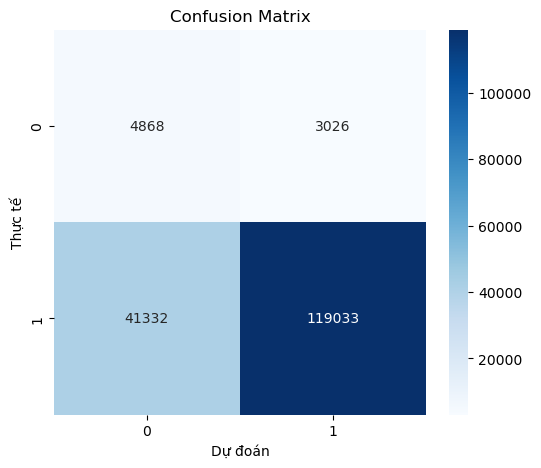

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.11      0.62      0.18      7894
           1       0.98      0.74      0.84    160365

    accuracy                           0.74    168259
   macro avg       0.54      0.68      0.51    168259
weighted avg       0.93      0.74      0.81    168259



In [ ]:
# 1. Confusion Matrix & Classification Report
cm = confusion_matrix(pred_pd["trend"], pred_pd["prediction"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix")
plt.show()

print("=== Classification Report ===")
print(classification_report(pred_pd["trend"], pred_pd["prediction"], zero_division=0))


Bước 12: Vẽ ROC Curve và tính AUC

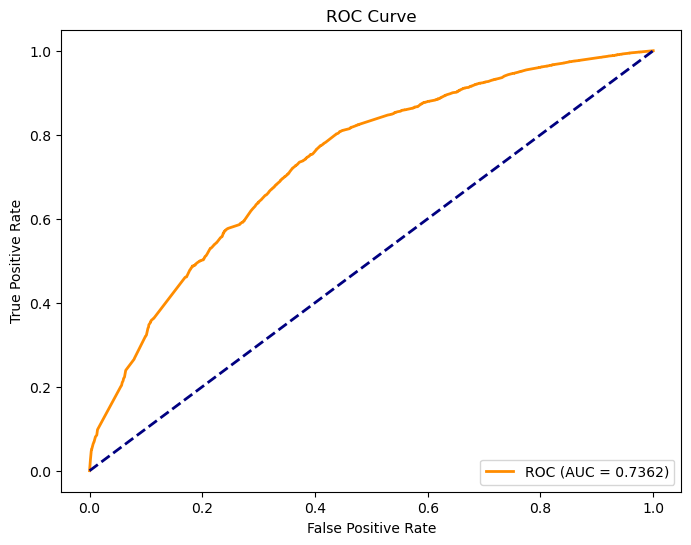

In [ ]:
# 2. ROC Curve & AUC
fpr, tpr, _ = roc_curve(pred_pd["trend"], pred_pd["prob_class1"])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


Bước 13: Vẽ biểu đồ Feature Importance

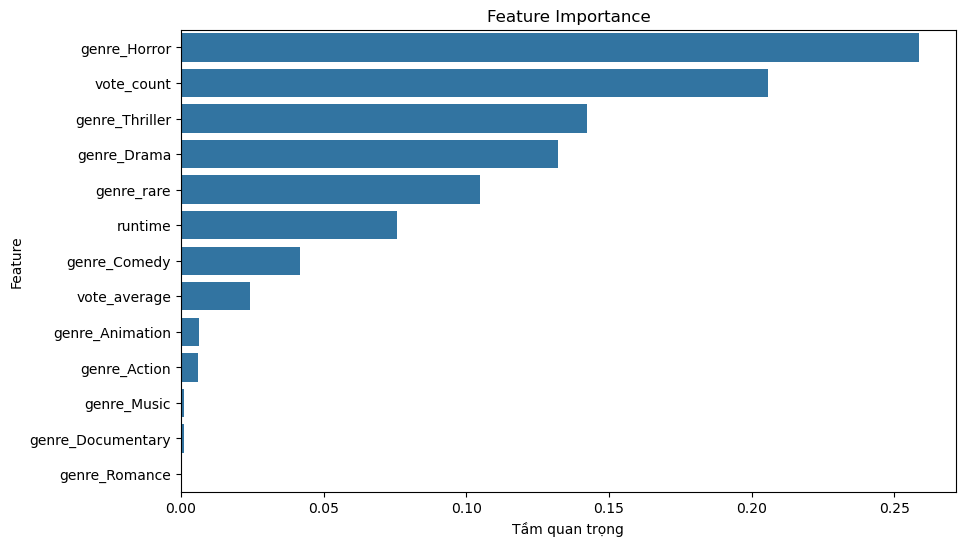

In [ ]:
# 3. Feature Importance
feat_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": model.featureImportances.toArray()
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feat_imp_df)
plt.title("Feature Importance")
plt.xlabel("Tầm quan trọng")
plt.ylabel("Feature")
plt.show()


Bước 14: EDA – Vẽ 3 biểu đồ khám phá dữ liệu gốc

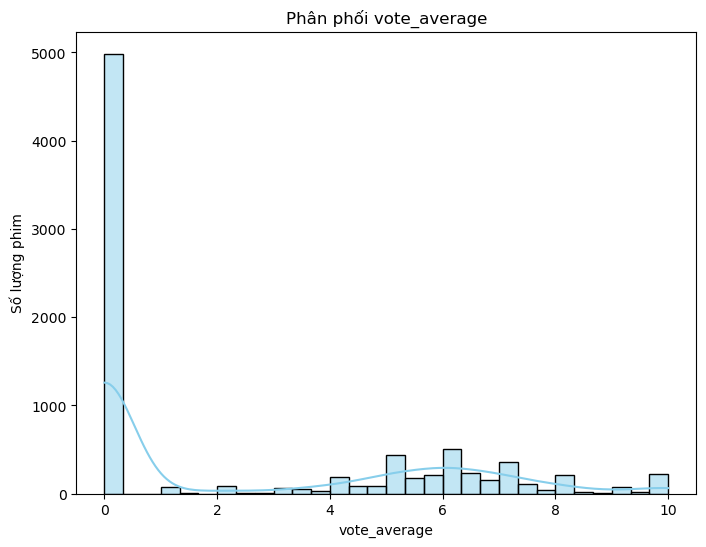

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_15976\3983214700.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre", y="count", data=genre_counts, palette="viridis")


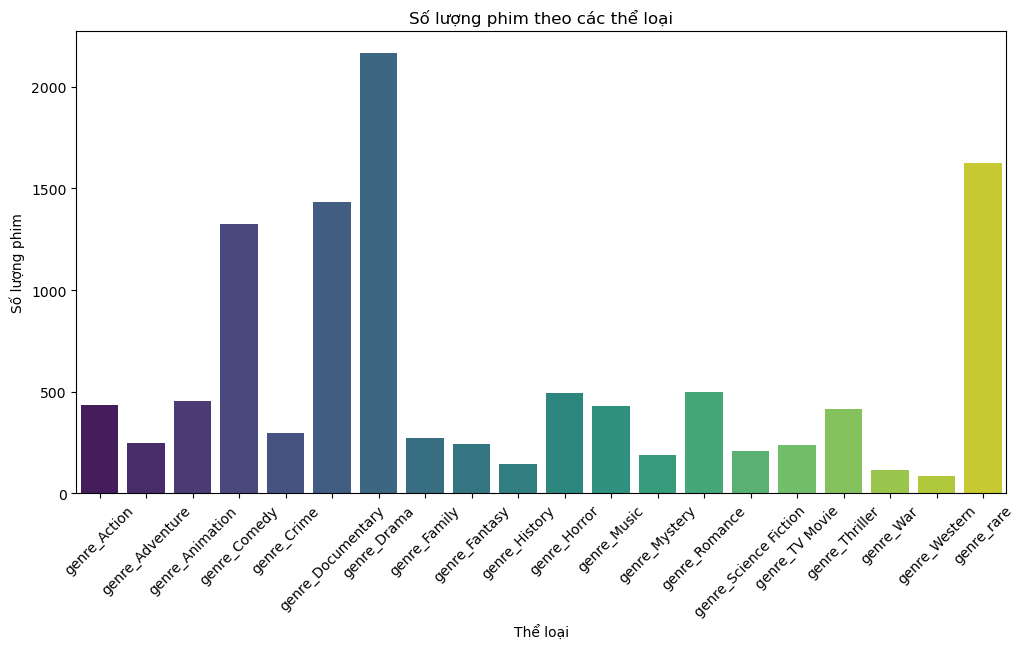

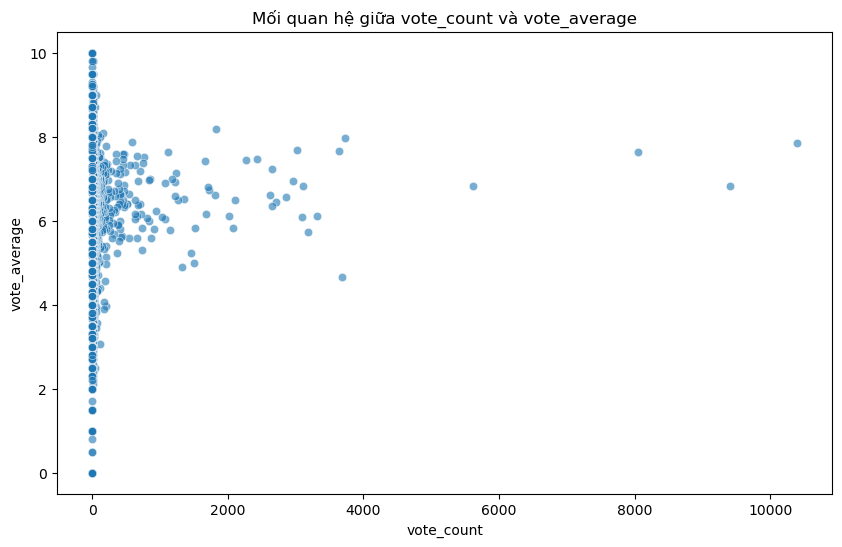

In [ ]:
# Lấy mẫu 1% dữ liệu gốc sang Pandas để tránh vấn đề bộ nhớ
data_pd = df.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()

# Biểu đồ phân phối vote_average
plt.figure(figsize=(8, 6))
sns.histplot(data_pd["vote_average"], bins=30, kde=True, color="skyblue")
plt.title("Phân phối vote_average")
plt.xlabel("vote_average")
plt.ylabel("Số lượng phim")
plt.show()

# Biểu đồ số lượng phim theo thể loại
genre_columns = [c for c in data_pd.columns if c.startswith("genre_")]
genre_counts = data_pd[genre_columns].sum().reset_index()
genre_counts.columns = ["genre", "count"]

plt.figure(figsize=(12, 6))
sns.barplot(x="genre", y="count", data=genre_counts, palette="viridis")
plt.title("Số lượng phim theo các thể loại")
plt.xlabel("Thể loại")
plt.ylabel("Số lượng phim")
plt.xticks(rotation=45)
plt.show()

# Biểu đồ phân tán giữa vote_count và vote_average
plt.figure(figsize=(10, 6))
sns.scatterplot(x="vote_count", y="vote_average", data=data_pd, alpha=0.6)
plt.title("Mối quan hệ giữa vote_count và vote_average")
plt.xlabel("vote_count")
plt.ylabel("vote_average")
plt.show()


Bước 15: Dừng Spark Session

In [ ]:
spark.stop()
